# 0. Introduction

This tutorial will:

- Use a small example dataset to show how to use wotplot to create and visualize dot plot matrices (**section 1**).

- Demonstrate a few techniques for creating fancy visualizations of dot plot matrices (**section 2**).

- Use wotplot to create and visualize a large dot plot matrix comparing two _E. coli_ genomes (**section 3**).

If you are unfamiliar with dot plot matrices, you may want to check out [the Wikipedia article on them](https://en.wikipedia.org/wiki/Dot_plot_(bioinformatics)). Chapter 6 of [_Bioinformatics Algorithms_](https://www.bioinformaticsalgorithms.org) also explains them well.

## 0.1. Import and set up a few things for later

In [1]:
import os
import wotplot as wp
from matplotlib import pyplot
# the facecolor and transparent kargs force the saved figures to have a white background;
# from https://stackoverflow.com/a/64585557
savefig_kwargs = {"bbox_inches": "tight", "facecolor": "white", "transparent": False}

# 1. A small example

## 1.1. Define a small dataset

Adapted from Figure 6.20 in Chapter 6 of _Bioinformatics Algorithms_ (Compeau & Pevzner), edition 2.

In [2]:
s1 = "AGCAGGAGATAAACCTGT"
s2 = "AGCAGGTTATCTACCTGT"
k = 3

## 1.2. Create a dot plot matrix

In [3]:
m = wp.DotPlotMatrix(s1, s2, k)

## 1.3. Inspect the dot plot matrix

In [4]:
type(m)

wotplot._matrix.DotPlotMatrix

In [5]:
m

DotPlotMatrix(mat=<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>, k=3, yorder="BT")

In [6]:
print(str(m))

DotPlotMatrix(k = 3, bottom → top): 16 x 16


The `DotPlotMatrix` object we just created, `m`, contains some extra information about the way it was created (e.g. the value of `k` we used). But the most interesting part of it is the actual matrix describing the dot plot! This matrix is stored in the `mat` attribute.

In [7]:
m.mat

<16x16 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>

### 1.3.1. Why is this matrix 16x16? Shouldn't it be 18x18?

You might have noticed that `s1` and `s2` are 18 nucleotides long. Why, then, does `m.mat` only have 16 rows and 16 columns?

The reason for this is that the number of $k$-mers in an arbitrary string $s$ is slightly smaller than $|s|$: it's $|s| - k + 1$. For `s1` and `s2`, $|s| - k + 1 = 18 - 3 + 1 = 16$.

### 1.3.2. What's the deal with sparse matrices?

Most dot plot matrices are _sparse_: that is, most of their entries are zeroes. We exploit this by storing `m.mat` in a [sparse matrix format](https://en.wikipedia.org/wiki/Sparse_matrix), which allows us to only bother storing the non-zero entries—this drastically reduces the memory requirements when our input sequences are long (more than a few thousand nucleotides).

#### Sidenote: what's the exact type of `m.mat`?
Depending on the version of SciPy you have installed, `m.mat` will be of type [`scipy.sparse.coo_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html) (SciPy < 1.8) or type [`scipy.sparse.coo_array`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_array.html) (SciPy ≥ 1.8). There shouldn't be much of a difference, at least for our use of these objects.

In [8]:
import scipy
print(f"This notebook is using SciPy version {scipy.__version__}.")

This notebook is using SciPy version 1.5.2.


In [9]:
type(m.mat)

scipy.sparse.coo.coo_matrix

It's possible to convert `m.mat` from this sparse format to an equivalent "dense" format; this can make the matrix easier to work with, although it might require a large amount of memory if your input sequences were long. (For relatively small sequences like `s1` and `s2`, though, we should be fine.)

Here's an example of creating a dense version of `m.mat`:

In [10]:
m.mat.toarray()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,

In the above matrix:

- `1` values represent cells where there there is a forward $k$-mer match,
- `-1` values represent cells where there is a reverse-complementary $k$-mer match, and
- `2` values represent cells where there is a palindromic $k$-mer match (i.e. both a forward and a reverse-complementary $k$-mer match), and
- `0` values represent cells where there are not any forward and/or reverse-complementary $k$-mer matches.

Note that there are no palindromic matches (i.e. `2` cells) in this example matrix.

## 1.4. Visualize the dot plot matrix

### 1.4.1. Available visualization functions
Currently, we provide two functions for visualizing these matrices: `viz_imshow()` and `viz_spy()`. Both of these are essentially wrappers for matplotlib's [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [`spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html) functions; you can even provide additional keyword arguments to `viz_imshow()` and `viz_spy()` which will be passed directly to `imshow()` / `spy()`. 

A brief summary of (in my opinion) the most important differences between these functions:

- `imshow()`
  - Draws zero and nonzero matrix cells as the same size, giving a "perfect" representation of the exact matrix.
    - For small matrices (e.g. both sequences < 200 nt), this looks nice.
    - For large matrices, the nonzero cells may be hard to see without enlarging the figure.
  - Doesn't support sparse matrices.
    - This means that `viz_imshow()` has to convert the sparse matrix to a dense format before calling `imshow()`. This will require a lot of memory if your matrix is large.


- `spy()`
  - Only draws nonzero matrix cells, meaning that the points representing each cell may cover other close-by cells in the matrix.
    - You can increase / decrease nonzero cells' sizes as desired via the `markersize` parameter.
    - For large matrices, this way of drawing things is actually nicer than the "perfect" representation offered by `imshow()` -- it makes nonzero cells much easier to see.
  - Works with sparse matrices.
    - This makes `viz_spy()` much more memory-efficient than `viz_imshow()`.

In general, I recommend using `viz_imshow()` for small matrices (e.g. both sequences < 200 nt) and `viz_spy()` for large matrices.

### 1.4.2. `viz_imshow()`

First, let's use `viz_imshow()` -- our sequences here are very short, so the total cost of storing a dense 16 x 16 = 256-cell matrix in memory is small.

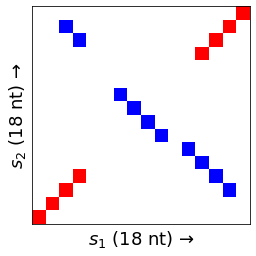

In [11]:
fig, ax = wp.viz_imshow(m)

# Since we include it in the README, we'll save this drawing to a file.
# We can do this using the fig object returned by viz_imshow() (or by viz_spy()).
# (If you don't care about saving / modifying your drawing, you can just run
# "wp.viz_imshow(m)" without saving the returned matplotlib Figure and Axes objects.)
fig.savefig(os.path.join("img", "small_example_dotplot.png"), **savefig_kwargs)

By default, the visualization will use:

- red cells (🟥) to represent forward matches (`1`),
- blue cells (🟦) to represent reverse-complementary matches (`-1`),
- purple cells (🟪) to represent palindromic matches (`2`), and
- white cells (⬜) to represent no matches (`0`).

### 1.4.3. For comparison's sake: `viz_spy()`

The default `markersize` used by `viz_spy()` is `0.5`. I set this as the default because it's useful for plots of very long sequences; however, it's less useful for plots of tiny sequences like this one.

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

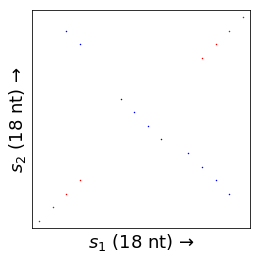

In [12]:
wp.viz_spy(m)

Those are some tiny dots! We can adjust the `markersize` when we call `viz_spy()`, which makes this visualization look essentially the same as what we'd get from `viz_imshow()`:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

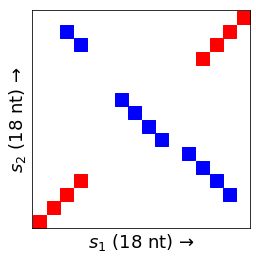

In [13]:
wp.viz_spy(m, markersize=13)

# 2. Fancy visualizations

## 2.1. Another small example dataset that includes palindromes

Just for demonstration, let's see how palindromic $k$-mers look in these visualizations. Note that palindromic $k$-mers can only occur for even values of $k$, since only even-length strings `s` can satisfy the condition `s == ReverseComplement(s)`; see [this discussion](https://bioinformatics.stackexchange.com/q/156) for details.

We'll create a "self dot plot," in which both the horizontal and vertical axes of the dot plot matrix correspond to the same sequence (named `s3` below). "Self dot plots" like this one can be helpful for visualizing self-similarity; for another example of a self dot plot, see [this visualization](https://commons.wikimedia.org/wiki/File:Zinc-finger-dot-plot.png) from [this Wikipedia page](https://en.wikipedia.org/wiki/Dot_plot_(bioinformatics)).

#### Sidenote: Aren't "self dot plots" like this symmetric?

Yep! Exactly _how_ your self dot plot is symmetric will depend on the `yorder` of your `wotplot.DotPlotMatrix` (see below), but all self dot plots will be symmetric in some way. If you wanted, you could only visualize one "triangle" of a self dot plot matrix; wotplot's built-in visualization functions don't support this (yet), but see [ModDotPlot](https://github.com/marbl/ModDotPlot) for an example of doing this.

Text(0, 0.5, '$s_3$ (21 nt) →')

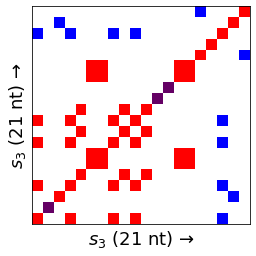

In [14]:
s3 = "AGCAGAAAGAGATAAACCTGT"
p = wp.DotPlotMatrix(s3, s3, 2)

fig, ax = wp.viz_imshow(p)

# Adjust labels to make clear that both axes correspond to the same sequence
s3_lbl = f"$s_3$ ({len(s3)} nt) \u2192"
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

There are three palindromic $k = 2$-mers in `s3` (listed in the table below). These 2-mers are shown as purple cells in the visualization above.

| 2-mer | Starting position in `s3` (0-indexed) |
| --- | --- |
| `GC` | 1 |
| `AT` | 11 |
| `TA` | 12 |

## 2.2. Adjusting the visualization color scheme

If you'd prefer something other than the default red / blue / purple / white colors, you can adjust this with the `nbcmap` parameters of `viz_imshow()` and `viz_spy()`.

### 2.2.1. For `viz_imshow()`

For `viz_imshow()`, `nbcmap` should be a `dict` mapping the four possible cell values (`0`, `1`, `-1`, `2`) to decimal RGB triplet colors (see [Wikipedia](https://en.wikipedia.org/wiki/Web_colors#Extended_colors) for context).

As an example, here we'll use `nbcmap` to create a "dark mode" version of the above dot plot:

Text(0, 0.5, '$s_3$ (21 nt) →')

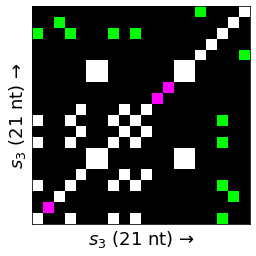

In [15]:
# it's gamer time
# no match = black; forward match = white; RC match = green; palindromic match = pink
dark_mode_cmap_255 = {0: [0, 0, 0], 1: [255, 255, 255], -1: [0, 255, 0], 2: [255, 0, 255]}

fig, ax = wp.viz_imshow(p, nbcmap=dark_mode_cmap_255)

ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

### 2.2.2. For `viz_spy()`

For `viz_spy()`, `nbcmap` should again be a `dict` mapping the four possible cell values (`0`, `1`, `-1`, `2`) -- but the values in this dictionary (representing the color each type of cell is represented by) **cannot be decimal RGB triplets**. See [matplotlib's documentation](https://matplotlib.org/stable/gallery/color/color_demo.html) for a list of accepted color formats; I think hex colors are probably easiest.

We'll recreate the above figure, but using `viz_spy()` and hex colors.

Text(0, 0.5, '$s_3$ (21 nt) →')

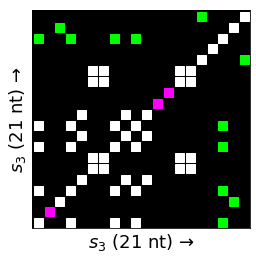

In [16]:
# no match = black; forward match = white; RC match = green; palindromic match = pink
dark_mode_cmap_hex = {0: "#000000", 1: "#ffffff", -1: "#00ff00", 2: "#ff00ff"}

# Using markersize=13 is a bit too big for this dataset, so let's use a smaller value
fig, ax = wp.viz_spy(p, markersize=9, nbcmap=dark_mode_cmap_hex)

ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

## 2.3. Binary visualizations

A lot of dot plot visualizations in the literature use black cells (⬛) to represent all match cells (forward, reverse-complementary, and palindromic), and white cells (⬜) to represent no-match cells.

If you would like to visualize a dot plot matrix in this "binary" way, you can pass the parameter `binary=True` to `viz_spy()` or `viz_imshow()`.

(If you're working with large datasets, this also has the nice side effect of making `viz_spy()` run slightly faster.)

Text(0, 0.5, '$s_3$ (21 nt) →')

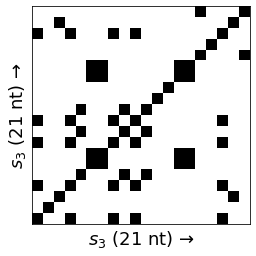

In [17]:
fig, ax = wp.viz_imshow(p, binary=True)
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

### 2.3.1. Adjusting the colors used for binary visualizations

#### 2.3.1.1. For `viz_imshow()`

You can adjust this using the `cmap` parameter, which can be set to any recognized [matplotlib colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html); the default is `"gray_r"`.

Text(0, 0.5, '$s_3$ (21 nt) →')

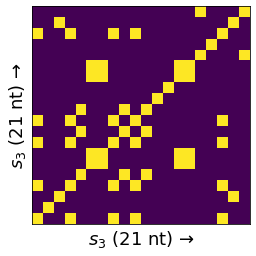

In [18]:
fig, ax = wp.viz_imshow(p, binary=True, cmap="viridis")
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

#### 2.3.1.2. For `viz_spy()`

You can adjust this using the `color` parameter, which should be in the color formats accepted by the `nbcmap` parameter of `viz_spy()` (e.g. hex colors).

Text(0, 0.5, '$s_3$ (21 nt) →')

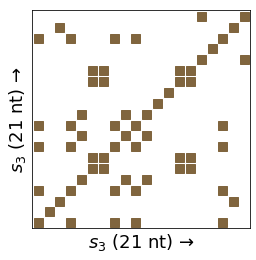

In [19]:
fig, ax = wp.viz_spy(p, markersize=9, binary=True, color="#80653e")
ax.set_xlabel(s3_lbl, fontsize=18)
ax.set_ylabel(s3_lbl, fontsize=18)

# (If you want to change the background color, also, you can call ax.set_facecolor().)

## 2.4. Flipping the y-axis

By default, wotplot visualizes dot plots in such a way that the sequence on the x-axis goes from left to right, and the sequence on the y-axis goes from bottom to top.

However, some dot plot visualizations (for example, [Gepard](https://academic.oup.com/bioinformatics/article/23/8/1026/198110)'s) "flip" the y-axis, so that the sequence on the y-axis goes from top to bottom.

If you would like to flip your y-axis in this way, you can set `yorder="TB"` when creating the dot plot matrix.

Note that, when you visualize a dot plot matrix, the direction of the arrow on the y-axis will be adjusted (to either ↑ or ↓) to reflect what direction your y-axis sequence is going in.

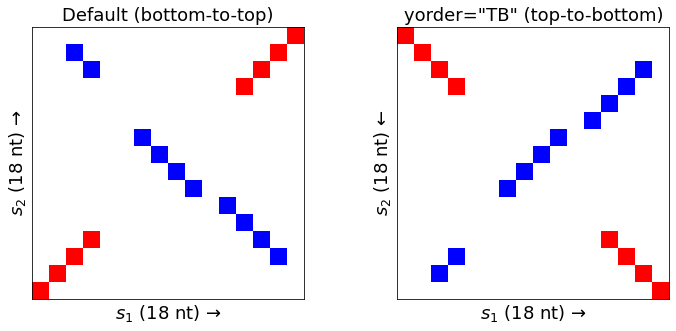

In [20]:
# Create another version of the original dot plot, but using yorder="TB"
m_flipped = wp.DotPlotMatrix(s1, s2, k, yorder="TB")

fig, (axLeft, axRight) = pyplot.subplots(1, 2)

# Notice how we provide an argument to the ax parameters of these functions.
# This way, we can create these Axes objects in advance (when we call pyplot.subplots()).
wp.viz_imshow(m, title="Default (bottom-to-top)", ax=axLeft)
wp.viz_imshow(m_flipped, title='yorder="TB" (top-to-bottom)', ax=axRight)

fig.set_size_inches(12, 5)

## 2.5. Tiling multiple dot plots

One of the main reasons I wrote this library was so that I could create figures containing grids of many dot plots using matplotlib. wotplot makes this process fairly painless!

The example above (showing flipping the y-axis) already demonstrates this, actually. The key idea is **using matplotlib's [`subplots`](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html) functionality to generate multiple `Axes` objects, then passing these objects to the `viz_spy()` or `viz_imshow()` functions using these functions' `ax` parameter**.

Here is a more intricate example than the one above, demonstrating how we can create a grid showing an all-versus-all comparison of five (pseudo)random sequences. In practice, this kind of figure could be useful for a situation where you want to compare a bunch of different types of sequences -- maybe different strains of a virus, or contigs within the same metagenome assembly bin, etc.

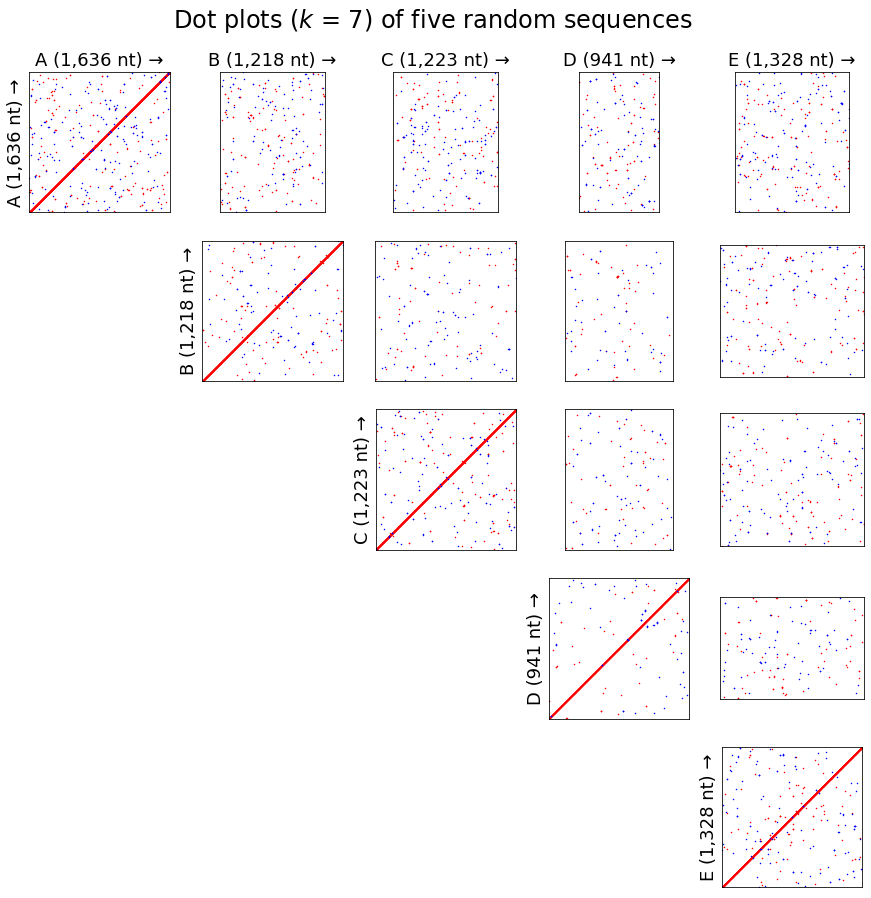

In [21]:
import random
# Set a seed so that we get the same results when we rerun this cell
random.seed(333)

def gen_random_seq(n):
    out = ""
    for i in range(n):
        out += random.choice("ACGT")
    return out

# create 5 random sequences of random lengths
lowlen = 500
highlen = 2000
seq_lens = [
    random.randrange(lowlen, highlen), random.randrange(lowlen, highlen), random.randrange(lowlen, highlen),
    random.randrange(lowlen, highlen), random.randrange(lowlen, highlen)
]
seqs = [gen_random_seq(slen) for slen in seq_lens]
seq_names = ["A", "B", "C", "D", "E"]

# Create a grid of dot plots
K = 7
fig, axes = pyplot.subplots(5, 5)
for row in range(0, 5):
    for col in range(0, 5):
        if col >= row:
            # Each sequence is assigned its own row and column ("A" in the top row and leftmost column,
            # "B" in the second-from-the-top row and second-from-the-left column, etc.)
            wp.viz_spy(
                wp.DotPlotMatrix(seqs[col], seqs[row], K),
                ax=axes[row, col],
                s1_name=seq_names[col],
                s2_name=seq_names[row],
            )
            # By default, each plot will have its own x- and y-axis label. To reduce clutter,
            # let's (i) only show x-axis labels on the top of the top row's plots ...
            if row == 0:
                axes[row, col].set_title(axes[row, col].get_xlabel(), fontsize=18)
            axes[row, col].set_xlabel("")
            # and (ii) only show y-axis labels on the left of the leftmost plots.
            if col != row:
                axes[row, col].set_ylabel("")
        else:
            # Since the "lower triangle" of this grid contains the same information as the upper triangle,
            # hide these plots using .axis("off") -- https://stackoverflow.com/a/25864515
            axes[row, col].axis("off")

fig.suptitle(f"Dot plots ($k$ = {K}) of five random sequences", fontsize=24, y=0.94)
fig.set_size_inches(15, 15)
fig.savefig(os.path.join("img", "grid.png"), **savefig_kwargs)

## 2.6. Passing arbitrary keyword arguments to `imshow()` / `spy()`

These functions have a lot of options available (see [the matplotlib docs for `imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) and [the matplotlib docs for `spy()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.spy.html)), and we can make use of these options without too much effort:

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

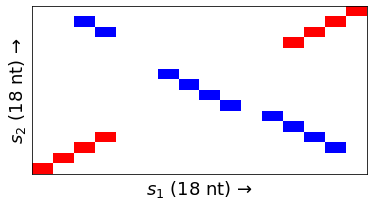

In [22]:
# - Set aspect to 0.5 (stretches out the x-axis; this can be useful if you're creating a dot plot where
#   the sequence used for the x-axis is much smaller than the sequence used for the y-axis).
wp.viz_imshow(m, aspect=0.5)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$s_1$ (18 nt) →', ylabel='$s_2$ (18 nt) →'>)

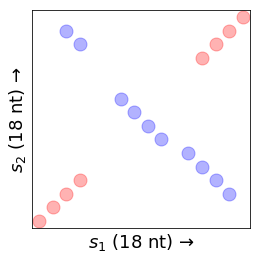

In [23]:
# - Set marker to "o" (draw circles instead of squares for matching cells).
# - Set alpha to 0.3 (add some transparency to the matching cells).
wp.viz_spy(m, markersize=13, marker="o", alpha=0.3)

## 2.7. Adding ticks, tick labels, and a grid (to make very fancy plots)
We'll show this by reusing the above example.

Adding ticks can be a little complicated, especially if we want the labels to be correct. So this code is a bit long, sorry -- I've tried to document it thoroughly to make it easier to read.

(Honestly, if you are reading this tutorial for the first time, you should probably just skip this section. I spent an embarrassing amount of time getting this to work right and now I'm too attached to this code to delete it.)

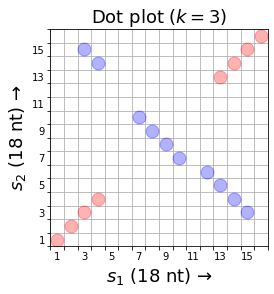

In [24]:
# While we're adding this other explanatory stuff, let's add a title for good measure.
fig, ax = wp.viz_spy(m, markersize=13, marker="o", alpha=0.3, title=f"Dot plot ($k = {m.k}$)")

###### PART 1: TICKS ######
# First, let's add ticks. We need to add ticks for ax.grid() to work.
# We'll add both major and minor ticks -- the major ticks will be used to position the grid lines,
# and the minor ticks will be used to position the tick labels. This allows us to center our labels
# in between ticks, which is nice when visualizing a matrix. This approach is inspired by
# https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html. (For context on major vs.
# minor ticks, see https://matplotlib.org/stable/gallery/ticks/major_minor_demo.html.)

# Our major ticks' positions will look like [-0.5, 0.5, 1.5, ..., 13.5, 14.5, 15.5]. We
# position them like this because the cells of the matrix occur at integer coordinates.
majticks = [t - 0.5 for t in range(0, 17)]

# We'll add minor ticks in between each of the major ticks. Our minor ticks use a smaller
# range than our major ticks because there are (n - 1) spaces between n consecutive points (e.g.
# your hands probably have 5 fingers each, but 4 spaces-between-fingers).
minticks = range(0, 16)

# The x-axis is simple -- we'll just use these major and minor ticks.
ax.set_xticks(majticks)
ax.set_xticks(minticks, minor=True)

# The y-axis is a bit more complicated. Keep in mind that, when creating the DotPlotMatrix "m"
# above, we left the DotPlotMatrix "yorder" parameter at its default value of "BT" -- so the
# y-axis goes from bottom to top.
#
# However, matplotlib doesn't know about this -- by default, it'll consider "row 0" to be the
# topmost row in the matrix, then row 1 the second-from-the-top row, ...)
# We can address this by adjusting the ticks on the y-axis (so that "row 0" is now the
# bottommost row, etc.) -- we'll do this using the t2y() function defined below.
def t2y(tl):
    return [m.mat.shape[0] - t - 1 for t in tl]
# Now, we can apply these corrected ticks to the y-axis.
ax.set_yticks(t2y(majticks))
ax.set_yticks(t2y(minticks), minor=True)

###### PART 2: TICK LABELS ######
# Next, let's add tick labels for the minor axis ticks. Adding one label for every minor tick
# is a bit excessive, so let's just add labels for every other minor tick. (For dot plots of
# long sequences, you'd probably want to add ticks and tick labels a lot farther apart -- e.g.
# separated by 1 Mbp.)
tick_labels = []
# Even though Python uses 0-indexing, we'll use 1-indexing here to make this plot a bit easier
# to interpret -- so we'll use range(1, 17) instead of range(0, 16).
for i in range(1, 17):
    if i % 2 == 1:
        # Only add labels for odd-numbered positions.
        tick_labels.append(f"{i:,}")
    else:
        # We still need to add something for the even-numbered positions (to match the
        # number of ticks we added above), so we'll add an empty string for each of these ticks.
        tick_labels.append("")

# Since we already reversed the ticks for the y-axis to account for how yorder="BT", we can now
# provide the tick labels for both the x- and y-axes in ascending order.
ax.set_xticklabels(tick_labels, minor=True)
ax.set_yticklabels(tick_labels, minor=True)

# Show ticks and labels on the left and bottom axes only
ax.tick_params(
    labeltop=False, labelbottom=True, labelleft=True, labelright=False,
    top=False, bottom=True, left=True, right=False, which="both"
)
# Also, don't show minor ticks' lines -- we'll still show their labels,
# but showing their tick lines (when we're already showing the major ticks' lines)
# is unnecessary (in my opinion)
ax.tick_params(bottom=False, left=False, which="minor")

###### PART 3: GRID LINES ######
# This part is easy :)
#
# We'll only draw grid lines for the major ticks -- this creates the nice appearance of minor
# ticks being lined up with their matrix rows / columns.
#
# Note that ax.grid() has a lot of other options you may want to play around with
# (linestyle, color, ...), should you want to make your dot plots even fancier.
ax.grid(which="major")

# 3. Creating dot plots of longer sequences

As a final example, let's create a dot plot of two _E. coli_ strains' genomes. We'll use _E. coli_ K-12 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000005845.2/) and _E. coli_ O157:H7 [(from this assembly)](https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000008865.2/).

I haven't included these FASTA files in the repository because they're both fairly large (both around ~5 MB), but -- for reference -- I downloaded them from the NCBI's website, moved them to a folder in this repository named `docs/data/`, and removed the two plasmid sequences from the O157:H7 assembly. (The K-12 assembly doesn't include any plasmid sequences; I guess this makes sense, given [the history of the K-12 strain](https://en.wikipedia.org/wiki/Escherichia_coli_in_molecular_biology#K-12)?)

In [25]:
# Note that pyfastx (https://github.com/lmdu/pyfastx), the library I use here to
# load these FASTA files' sequences into memory, isn't included as a dependency of
# wotplot; you can load your sequences however you'd like.
import pyfastx
e1 = pyfastx.Fasta(os.path.join("data", "ecoli_k12.fna"))
e2 = pyfastx.Fasta(os.path.join("data", "ecoli_o157h7.fna"))

In [26]:
# Extract the sequences from these pyfastx.Fasta objects
e1s = str(e1[0])
e2s = str(e2[0])

#### Sidenote: how do I select the $k$-mer size when dealing with big sequences?
I don't have a single perfect answer. In general: smaller values of $k$ will show more details, but they'll increase the number of random matches between the two sequences, which will in turn increase the density of the dot plot matrix, which will in turn increase the memory footprint of the matrix. So you should consider the length of your sequences, their expected degree of similarity, what sort of "signals" you're looking for, and how much memory your system has when selecting the $k$-mer size.

If you're really curious, here are some vague, informal suggestions that might be a good starting point. For tiny sequences (e.g. < 100 bp), any $k$ should be ok. For small-ish sequences (e.g. 100 bp – 1 kbp), any $k > 2$ should be ok. For sequences in the range 1–100 kbp, I tend to use $k = 10$. For large sequences (e.g. > 100 kbp), I recommend using $k > 10$. (But none of this is written in stone, so please don't quote me on it...)

#### Sidenote: I didn't read that sidenote and you're bad at writing documentation
Wow, that's kind of harsh??? But don't worry, you didn't miss much.

## 3.1. Creating a dot plot matrix for the two _E. coli_ strains

We'll use a $k$-mer size of $k$ = 20. We'll also set `verbose=True` in order to get detailed logging output as the matrix is constructed -- this helps reassure us that wotplot isn't frozen.

In [27]:
em = wp.DotPlotMatrix(e1s, e2s, 20, verbose=True)

0.00s: Validating inputs...
0.47s: Will find matches using common_substrings().
0.47s: Finding forward matches between s1 and s2...
20.19s: Found 3,357,713 forward match cell(s).
20.19s: Computing ReverseComplement(s2)...
20.22s: Finding reverse-complementary matches between s1 and s2...
27.36s: Found 3,536,693 total (fwd and/or RC) match cell(s).
27.36s: Dot plot matrix density = 0.00%.
27.37s: Converting match information to COO format inputs...
29.24s: Creating sparse matrix from COO format inputs...
30.38s: Done creating the matrix.


Creating the matrix usually takes about 30 seconds (on my six-year old laptop with 8 GB of RAM). (... Or closer to 40 seconds when I have a lot of stuff open.) All things considered, not too shabby!

#### Sidenote: setting `suff_only=True` when creating the matrix to use a lower-memory, slower method

If you would like to create a dot plot matrix of very long sequences, and your system has a limited amount of memory, then creating the matrix might require too much memory for your system. (For my laptop with 8 GB of RAM, things start getting dicey when both sequences are above ~10 Mbp.)

If you don't mind taking a bit longer, you can use the optional `suff_only=True` parameter when running `wp.DotPlotMatrix()` to use a different method. This different method requires less memory, at the cost of taking longer to run. Please see the "Two methods for finding shared _k_-mers" section of the README for more details.

## 3.2. Visualizing the _E. coli_ dot plot matrix

Now let's visualize the matrix. We pretty much have to use `viz_spy()` here -- using `viz_imshow()` is not feasible, because creating a dense-format copy of this matrix would require us to have... wait, how many cells were in that matrix?

In [28]:
em.mat.shape

(5498559, 4641633)

In [29]:
f"The matrix has {em.mat.shape[0] * em.mat.shape[1]:,} cells."

'The matrix has 25,522,292,906,847 cells.'

Okay, so if we make the unrealistic assumption that each cell in the matrix can somehow be stored in a single bit, then we'd still need ~3.19 terabytes (!!!) of memory to store the matrix in dense format. That's not happening on my laptop, so we'll have to use `viz_spy()`.

Again, we can use `verbose=True` for `viz_spy()` in order to get information about how long visualization is taking. (This should go by quickly, though -- visualization is fast, compared to the process of creating the matrix.)

0.03s: binary is not True, so we'll draw matches in different colors.
0.03s: Visualizing "1" cells with spy()...
0.42s: Done visualizing "1" cells.
0.42s: Visualizing "-1" cells with spy()...
0.66s: Done visualizing "-1" cells.
0.66s: Visualizing "2" cells with spy()...
0.91s: Done visualizing "2" cells.
0.91s: Slightly restyling the visualization...
0.91s: Done.


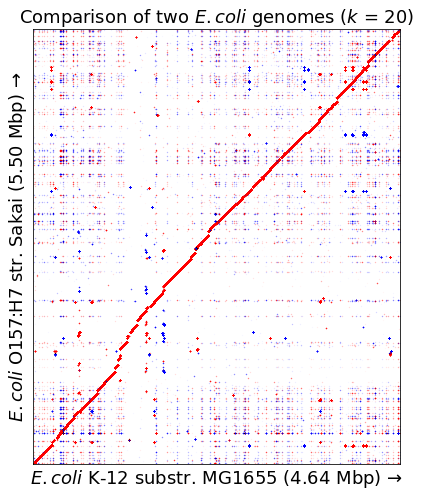

In [30]:
fig, ax = wp.viz_spy(
    em, markersize=0.01, title=f"Comparison of two $E. coli$ genomes ($k$ = {em.k})", verbose=True
)
ax.set_xlabel(f"$E. coli$ K-12 substr. MG1655 ({len(e1s)/1e6:.2f} Mbp) \u2192")
ax.set_ylabel(f"$E. coli$ O157:H7 str. Sakai ({len(e2s)/1e6:.2f} Mbp) \u2192")
fig.set_size_inches(8, 8)
fig.savefig(os.path.join("img", "ecoli_example_dotplot.png"), **savefig_kwargs)

There we have it! You may want to play around with the `markersize` parameter a bit in order to see what looks best.

## 3.3. Visualizing the _E. coli_ dot plot matrix with `binary=True`

When we're working with long sequences like these, the process of dot plot matrix visualization is (very slightly) faster if we draw all match cells as the same color.

0.05s: binary is True; visualizing all match cells with spy()...
0.24s: Done visualizing all match cells.
0.24s: Slightly restyling the visualization...
0.24s: Done.


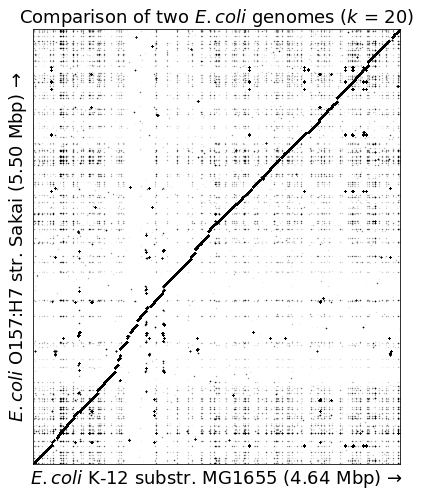

In [31]:
# This code is the exact same as the above visualization of the binary E. coli matrix, except for binary=True
fig, ax = wp.viz_spy(
    em, markersize=0.01, title=f"Comparison of two $E. coli$ genomes ($k$ = {em.k})", binary=True, verbose=True
)
ax.set_xlabel(f"$E. coli$ K-12 substr. MG1655 ({len(e1s)/1e6:.2f} Mbp) \u2192")
ax.set_ylabel(f"$E. coli$ O157:H7 str. Sakai ({len(e2s)/1e6:.2f} Mbp) \u2192")
fig.set_size_inches(8, 8)